In [134]:
import numpy as np
import pandas as pd
import seaborn as sbn
import pickle as pkl
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn import linear_model
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error,make_scorer
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn import metrics
from math import log
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.patches as mpatches
# %pylab inline

def plot_prob_timeline(data,label):
    xtick = range(0, 91, 10)
    fig = plt.figure()
    a = plt.plot(data[:,0])
    d = plt.plot(data[:,1])
    h = plt.plot(data[:,2])
    fig.suptitle(label, fontsize=20)
    dim = 300
    plt.ylim([0,1])

    plt.xlabel('Time', fontsize=18)
    plt.ylabel('Probability', fontsize=16)
    blue_patch = mpatches.Patch(color='blue', label='Away')
    orange_patch = mpatches.Patch(color='orange', label='Draw')
    green_patch = mpatches.Patch(color='green', label='Home')

    plt.legend(handles=[blue_patch,orange_patch,green_patch])
    plt.xticks(xtick)
    plt.show()
    return fig

def eval_probs(y_prob,y_test, labels=[-1,0,1],show_plot=False):
    """
    y_prob : predict_proba output of a model
    labels : all unique labels in the classification
    """
    vals = []
    titles = {}
    titles[-1] = "Away Win"
    titles[0] = "Draw"
    titles[1] = "Home Win"

    y_prob = pd.DataFrame(y_prob, columns=[-1, 0, 1])
    y_prob = y_prob.round(1)
    y_prob['label'] = y_test.reset_index(drop=True)
    slopes= []
    total_error = 0
    for ind, label in enumerate(labels):
        vals = sorted(y_prob[label].unique())
        
        y_col = []
        
        
        for i in vals:
            tot_len = y_prob[(y_prob[label] == i)].shape[0]
            matching_len = y_prob[(y_prob[label] == i) & (y_prob['label'] == label)].shape[0]
            y_col.append(matching_len*1.0/tot_len)
        
        index = 0
        y_true = 0
        for i in range(10):
            if index == len(y_col):
                y = 0
            else:
                y = y_col[index]
                index+=1
            total_error+= (y_true - y)**2
            y_true+=0.1
        perfect_values = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
        if show_plot:
            plt.figure(figsize=(7,21))
            plt.subplot(311+ind)
            plt.bar(vals, y_col, width=0.05,label="Model Performance")
            plt.title(titles[label], fontsize=16)
            plt.xticks(np.arange(0.0, 1.1, 0.1), fontsize=8)
            plt.yticks(np.arange(0.0, 1.1, 0.1),fontsize=8)
            plt.plot(perfect_values,perfect_values,'r--',label="Ideal Values")
            plt.legend(loc=0)
            plt.show()
    return total_error ** 0.5
        
    
def save_model(model, model_name):
    saved_models_root = "./saved_models/" 
    filename = saved_models_root + model_name + datetime.now().strftime('%m%d_%H%M%S') + ".pkl"
                                                 
    with open(filename, 'wb') as outfile:
        pkl.dump(model, outfile)

In [2]:
with open("./data/train/train_data.pkl") as infile:
    train_data = pkl.load(infile)
train_data = train_data.loc[train_data['match_id'] != 1510605206930]
train_data.shape
# with open("./data/train/train_data_with_team_attr.pkl") as infile:
#     train_data = pkl.load(infile)

(152073, 106)

In [3]:
# train_data.columns.values
temp_data = train_data.copy(deep = True)
# train_data  = temp_data.copy(deep = True)

In [4]:
train_data.columns.values

array(['season', 'stage', 'date_x', 'match_api_id', 'home_team_api_id',
       'away_team_api_id', 'home_player_1', 'home_player_2',
       'home_player_3', 'home_player_4', 'home_player_5', 'home_player_6',
       'home_player_7', 'home_player_8', 'home_player_9', 'home_player_10',
       'home_player_11', 'away_player_1', 'away_player_2', 'away_player_3',
       'away_player_4', 'away_player_5', 'away_player_6', 'away_player_7',
       'away_player_8', 'away_player_9', 'away_player_10',
       'away_player_11', 'goal', 'shoton', 'shotoff', 'foulcommit', 'card',
       'cross', 'corner', 'possession', 'B365H', 'B365D', 'B365A', 'BWH',
       'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 'LBA', 'PSH',
       'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'SJH', 'SJD', 'SJA', 'VCH',
       'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD', 'BSA', 'home_team',
       'away_team', 'buildUpPlaySpeed_x', 'buildUpPlayPassing_x',
       'chanceCreationPassing_x', 'chanceCreationCrossing_x',
       'chan

In [5]:
columns = ['date', 'B365H', 'B365D', 'B365A', 'home_team', 'away_team', 
           'winner', 'minute', 'H_Goal', 'A_Goal','goal_diff','home_avg_player_rating',
       'home_avg_player_potential', 'away_avg_player_rating',
       'away_avg_player_potential','H_Y_Card', 'A_Y_Card', 'H_R_Card', 'A_R_Card']
def preprocessData(train_data):
    train_data['goal_diff'] = train_data['H_Goal'] - train_data['A_Goal']
    train_data = train_data[columns]
    train_data.drop_duplicates(inplace=True, keep='first')
    X = train_data.drop(['winner', 'date', 'home_team', 'away_team'], axis=1)
    Y = train_data['winner']
    return (X,Y)

In [6]:
train_data['goal_diff'] = train_data['H_Goal'] - train_data['A_Goal']

In [7]:
# columns = ['date', 'B365H', 'B365D', 'B365A', 'home_team', 'away_team', 
#            'winner', 'minute', 'H_Goal', 'A_Goal','buildUpPlaySpeed_x', 'buildUpPlayPassing_x',
#        'chanceCreationPassing_x', 'chanceCreationCrossing_x',
#        'chanceCreationShooting_x', 'defencePressure_x',
#        'defenceAggression_x', 'defenceTeamWidth_x', 'buildUpPlaySpeed_y',
#        'buildUpPlayPassing_y', 'chanceCreationPassing_y',
#        'chanceCreationCrossing_y', 'chanceCreationShooting_y',
#        'defencePressure_y', 'defenceAggression_y', 'defenceTeamWidth_y','goal_diff','home_avg_player_rating',
#        'home_avg_player_potential', 'away_avg_player_rating',
#        'away_avg_player_potential','H_Y_Card', 'A_Y_Card', 'H_R_Card', 'A_R_Card']

columns = ['date', 'B365H', 'B365D', 'B365A', 'home_team', 'away_team', 
           'winner', 'minute', 'H_Goal', 'A_Goal','goal_diff','home_avg_player_rating',
       'home_avg_player_potential', 'away_avg_player_rating',
       'away_avg_player_potential','H_Y_Card', 'A_Y_Card', 'H_R_Card', 'A_R_Card']
train_data = train_data[columns]

In [8]:
train_data.shape

(152073, 19)

In [9]:
# train_data.card.value_counts()

In [10]:
# train_data[(train_data['match_id']==1510566245714) & (train_data['minute']>=45)]

In [11]:
train_data.drop_duplicates(inplace=True, keep='first')

In [12]:
# train_data.match_id.value_counts()

In [13]:
# X = train_data.drop(['winner', 'date', 'match_id', 'home_team', 'away_team'], axis=1)
X = train_data.drop(['winner', 'date', 'home_team', 'away_team'], axis=1)

Y = train_data['winner']

In [63]:
(X,Y) = preprocessData(train_data)

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [64]:
X['home_avg_player_potential'].value_counts()

0.0    150360
Name: home_avg_player_potential, dtype: int64

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

## Support Vector Classifier

In [ ]:
svc = svm.SVC(probability=True,cache_size=99999)
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)

print metrics.accuracy_score(y_test, y_pred)

y_prob = svc.predict_proba(X_test)

## Logistic Regression

In [61]:
lr = LogisticRegression(n_jobs=-1,solver='saga',class_weight='balanced')
lr.fit(X_train,y_train)

y_pred = lr.predict(X_test)

print metrics.accuracy_score(y_test, y_pred)

y_prob = lr.predict_proba(X_test)

# eval_probs(y_prob, y_test, [-1,0,1])

0.634857256938


C:\ProgramData\Anaconda2\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


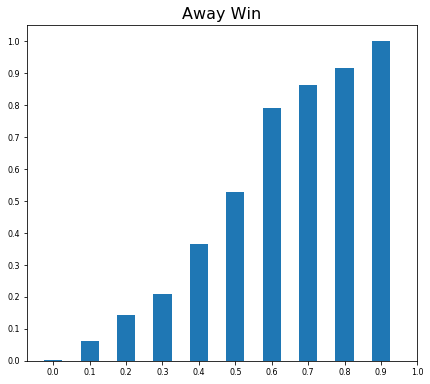

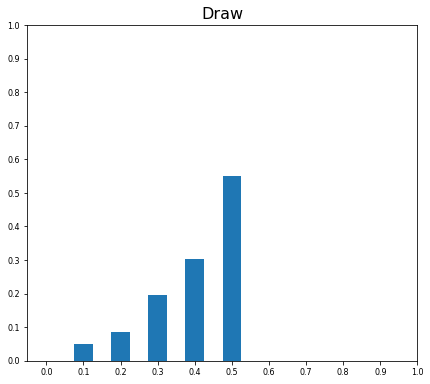

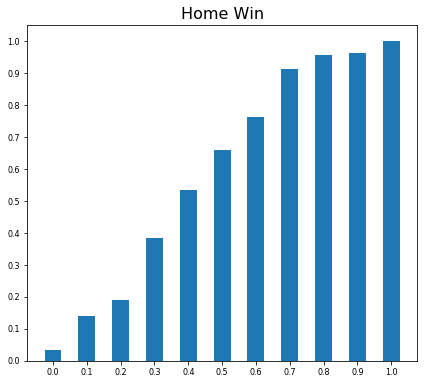

1.6101008098229135

In [70]:
eval_probs(y_prob, y_test, [-1,0,1], True)

In [16]:
temp_data = temp_data[columns]
X = temp_data.drop(['winner'], axis=1)
Y = temp_data['winner']
X_trainA, X_testA, y_trainA, y_testA = train_test_split(X, Y, test_size=0.1,shuffle= False)


In [63]:
# head = X_testA #1510605206930   1510602646114
# match_data = head.loc[head['match_id'] == 1510605206930]
# match_data=match_data.drop([  'date', 'match_id', 'home_team', 'away_team'], axis=1)
# y_prob= lr.predict_proba(match_data)


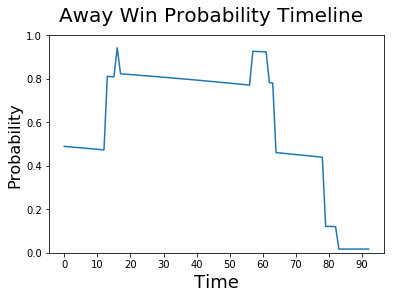

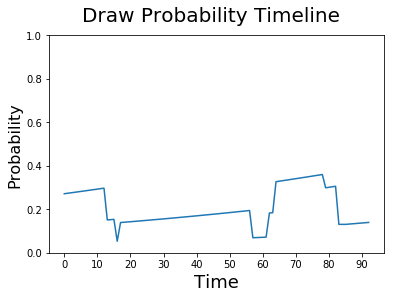

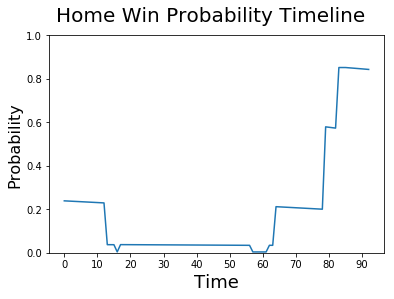

In [142]:
plot_prob_timeline(y_prob[:,0],'Away Win Probability Timeline')
plot_prob_timeline(y_prob[:,1],'Draw Probability Timeline')
plot_prob_timeline(y_prob[:,2],'Home Win Probability Timeline')

In [132]:
# y_zzzzprob[:,0],'Away Win Probability Timeline'


## K nearest neighbours

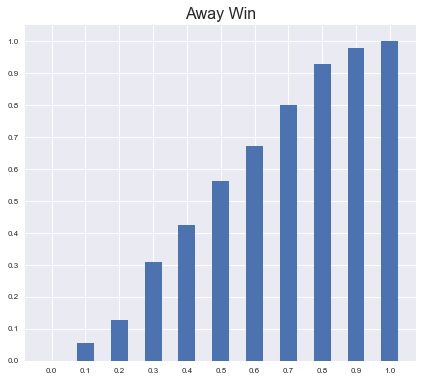

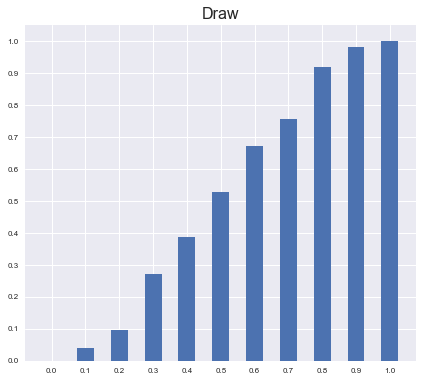

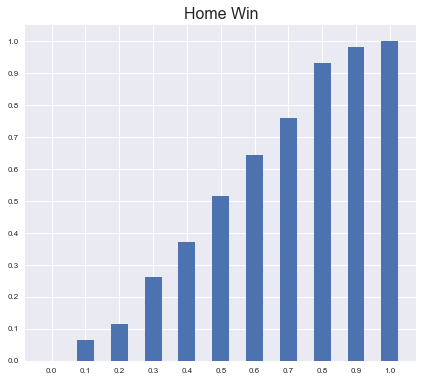

0.366996032127


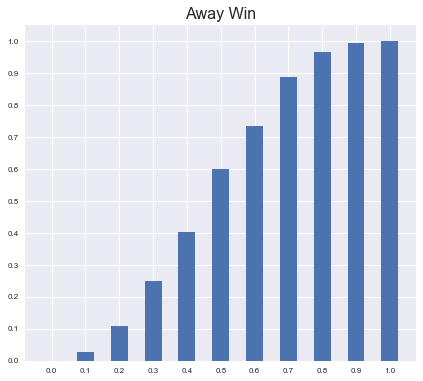

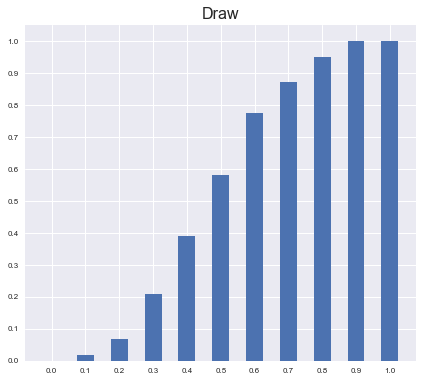

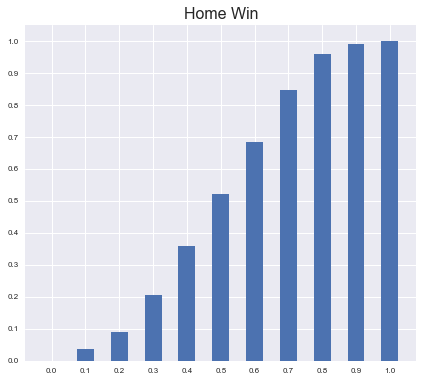

0.580481774604


In [34]:
#last checked, worked better with scaled data (0.98 RMSE)
for weight in ['uniform' , 'distance']:

    neigh = KNN(n_neighbors=15, algorithm='auto', weights=weight, n_jobs=-1)
    neigh.fit(X_train, y_train) 
    
    y_pred = neigh.predict(X_test)

#     print metrics.accuracy_score(y_test, y_pred)

    y_prob = neigh.predict_proba(X_test)
    print eval_probs(y_prob, y_test, [-1,0,1],show_plot=True)    
    
    
#     save_model(neigh, "KNN"+weight)

## Random Forest Classifier

0.724362813602


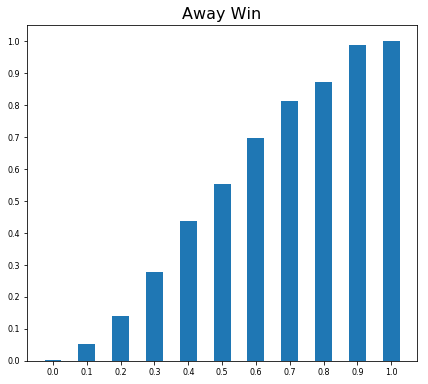

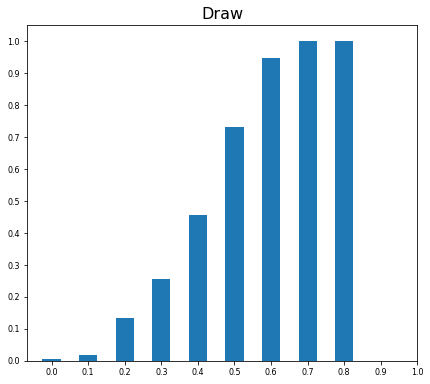

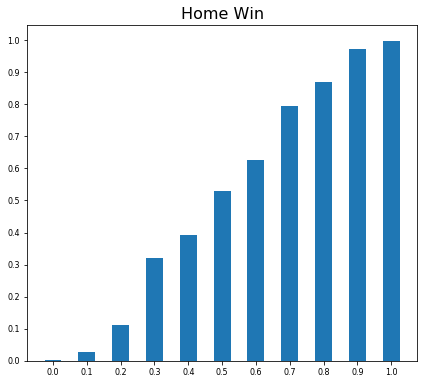

1.0992550058917738

In [57]:
rf = RandomForestClassifier(n_estimators=15,max_depth=8,n_jobs=-1)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

print metrics.accuracy_score(y_test, y_pred)

y_prob = rf.predict_proba(X_test)

eval_probs(y_prob, y_test, [-1,0,1],show_plot=True)

In [37]:
X_train.shape

(135324, 15)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
0.712650562321


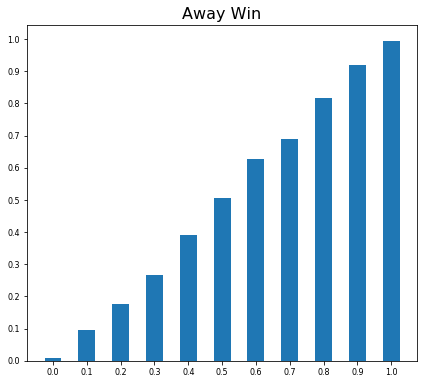

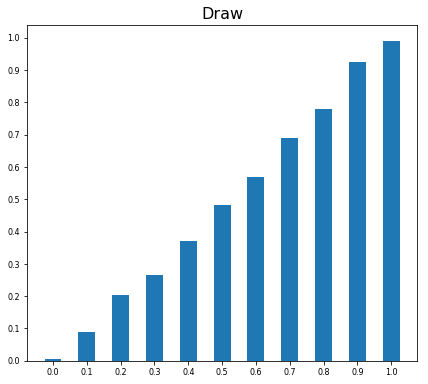

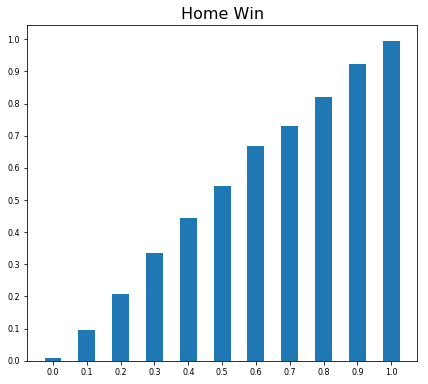

0.14147188128949123

In [53]:
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), activation='tanh', solver='adam', learning_rate='constant',
                   learning_rate_init=0.0001, max_iter=100, early_stopping=False, tol=0.00001, verbose=False,
                   warm_start=True)

for i in range(200):
    print i
    mlp.fit(X_train,y_train)

y_pred = mlp.predict(X_test)

print metrics.accuracy_score(y_test, y_pred)

y_prob = mlp.predict_proba(X_test)

eval_probs(y_prob, y_test, [-1,0,1],show_plot=True)

In [81]:
with open("./data/train/train_data.pkl") as infile:
    temp_data = pkl.load(infile)


In [82]:
match_ids = temp_data['match_id']

In [ ]:
for i in range(1,len(match_ids)):
    print match_ids[i]

1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
1510571589386
151057

1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
1510571045447
151057

1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
1510572258272
151057

1510571135728
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
1510570568175
151057

1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510572126632
1510571084122
1510571084122
1510571084122
1510571084122
1510571084122
151057

1510570900417
1510570900417
1510570900417
1510570900417
1510570900417
1510570900417
1510570900417
1510570900417
1510570900417
1510570900417
1510570900417
1510570900417
1510570900417
1510572012452
1510572012452
1510572012452
1510572012452
1510572012452
1510572012452
1510572012452
1510572012452
1510572012452
1510572012452
1510572012452
1510572012452
1510572012452
1510572012452
1510572012452
1510572012452
1510572012452
1510572012452
1510572012452
1510572012452
1510572012452
1510572012452
1510572012452
1510572012452
1510572012452
1510572012452
1510572012452
1510572012452
1510572012452
1510572012452
1510572012452
1510572012452
1510572012452
1510572012452
1510572012452
1510572012452
1510572012452
1510572012452
1510572012452
1510572012452
1510572012452
1510572012452
1510572012452
1510572012452
1510572012452
1510572012452
1510572012452
1510572012452
1510572012452
1510572012452
1510572012452
1510572012452
1510572012452
1510572012452
1510572012452
1510572012452
1510572012452
1510572012452
151057

1510572329877
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
1510570854811
151057

1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
1510570904026
151057

1510572047661
1510572047661
1510572047661
1510572047661
1510572047661
1510572047661
1510572047661
1510572245225
1510572245225
1510572245225
1510572245225
1510572245225
1510572245225
1510572245225
1510572245225
1510572245225
1510572245225
1510572245225
1510572245225
1510572245225
1510572245225
1510572245225
1510572245225
1510572245225
1510572245225
1510572245225
1510572245225
1510572245225
1510572245225
1510572245225
1510572245225
1510572245225
1510572245225
1510572245225
1510572245225
1510572245225
1510572245225
1510572245225
1510572245225
1510572245225
1510572245225
1510572245225
1510572245225
1510572245225
1510572245225
1510572245225
1510572245225
1510572245225
1510572245225
1510572245225
1510572245225
1510572245225
1510572245225
1510572245225
1510572245225
1510572245225
1510572245225
1510572245225
1510572245225
1510572245225
1510572245225
1510572245225
1510572245225
1510572245225
1510572245225
1510572245225
1510572245225
1510572245225
1510572245225
1510572245225
1510572245225
151057

1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
1510572167364
151057

1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
1510571687667
151057

1510570744421
1510570744421
1510570744421
1510570744421
1510570744421
1510570744421
1510570744421
1510570744421
1510570744421
1510570744421
1510570744421
1510570744421
1510570744421
1510570744421
1510570744421
1510570744421
1510570744421
1510570744421
1510570744421
1510570744421
1510570744421
1510570744421
1510570744421
1510570744421
1510570744421
1510570744421
1510570744421
1510570744421
1510570744421
1510570744421
1510570744421
1510570744421
1510570744421
1510570744421
1510570744421
1510570744421
1510570744421
1510570744421
1510570744421
1510570744421
1510570744421
1510570744421
1510570744421
1510570744421
1510570744421
1510570744421
1510570744421
1510570744421
1510570744421
1510570744421
1510570744421
1510570744421
1510570744421
1510570744421
1510571877515
1510571877515
1510571877515
1510571877515
1510571877515
1510571877515
1510571877515
1510571877515
1510571877515
1510571877515
1510571877515
1510571877515
1510571877515
1510571877515
1510571877515
1510571877515
1510571877515
151057

1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
1510573365933
151057

1510574498848
1510574498848
1510574498848
1510574498848
1510574498848
1510574498848
1510574498848
1510574498848
1510574498848
1510574498848
1510574498848
1510574498848
1510574498848
1510574498848
1510574498848
1510574498848
1510574498848
1510574498848
1510574498848
1510574498848
1510574498848
1510574498848
1510574498848
1510574498848
1510574498848
1510574498848
1510574498848
1510574498848
1510574498848
1510574498848
1510574498848
1510574498848
1510574498848
1510574498848
1510574498848
1510574498848
1510574498848
1510574498848
1510574498848
1510574498848
1510574498848
1510574498848
1510574498848
1510574498848
1510574498848
1510574498848
1510574498848
1510574498848
1510574498848
1510574498848
1510574498848
1510574498848
1510574498848
1510574498848
1510574498848
1510574498848
1510574452346
1510574452346
1510574452346
1510574452346
1510574452346
1510574452346
1510574452346
1510574452346
1510574452346
1510574452346
1510574452346
1510574452346
1510574452346
1510574452346
1510574452346
151057

1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
1510572893968
151057

In [123]:
plot_data = temp_data.loc[temp_data['match_id'] == 1510573681650]
X,Y= preprocessData(plot_data)
y_prob = mlp.predict_proba(X)

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [141]:
X

,B365H,B365D,B365A,minute,H_Goal,A_Goal,goal_diff,home_avg_player_rating,home_avg_player_potential,away_avg_player_rating,away_avg_player_potential,H_Y_Card,A_Y_Card,H_R_Card,A_R_Card
29493,1.73,3.4,5.5,0,0,0,0,155.0,0.0,153.181818,0.0,0,0,0,0
29494,1.73,3.4,5.5,1,0,0,0,155.0,0.0,153.181818,0.0,0,0,0,0
29495,1.73,3.4,5.5,2,0,0,0,155.0,0.0,153.181818,0.0,0,0,0,0
29496,1.73,3.4,5.5,3,0,0,0,155.0,0.0,153.181818,0.0,0,0,0,0
29497,1.73,3.4,5.5,4,0,0,0,155.0,0.0,153.181818,0.0,0,0,0,0
29498,1.73,3.4,5.5,5,0,0,0,155.0,0.0,153.181818,0.0,0,0,0,0
29499,1.73,3.4,5.5,6,0,0,0,155.0,0.0,153.181818,0.0,0,0,0,0
29500,1.73,3.4,5.5,7,0,0,0,155.0,0.0,153.181818,0.0,0,0,0,0
29501,1.73,3.4,5.5,8,0,0,0,155.0,0.0,153.181818,0.0,0,0,0,0
29502,1.73,3.4,5.5,9,0,0,0,155.0,0.0,153.181818,0.0,0,0,0,0


(91L, 3L)


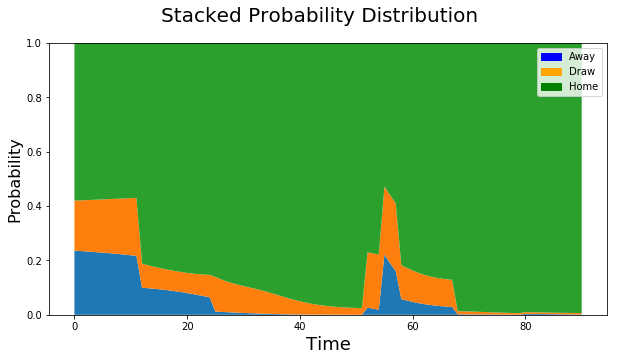

In [136]:
data = y_prob
label = "Stacked Probability Distribution"
# x = range(0, 91, 10)
# fig = plt.figure()
x = np.arange(data.shape[0])
fig, ax = plt.subplots()
print y_prob.shape
fig.suptitle(label, fontsize=20)
plt.ylim([0,1])
fig.set_figheight(5)
fig.set_figwidth(10)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Probability', fontsize=16)
blue_patch = mpatches.Patch(color='blue', label='Away')
orange_patch = mpatches.Patch(color='orange', label='Draw')
green_patch = mpatches.Patch(color='green', label='Home')

plt.legend(handles=[blue_patch,orange_patch,green_patch])
y_prob.reshape(3,-1)
temp =y_prob.T
ax.stackplot(x, temp)
plt.show()


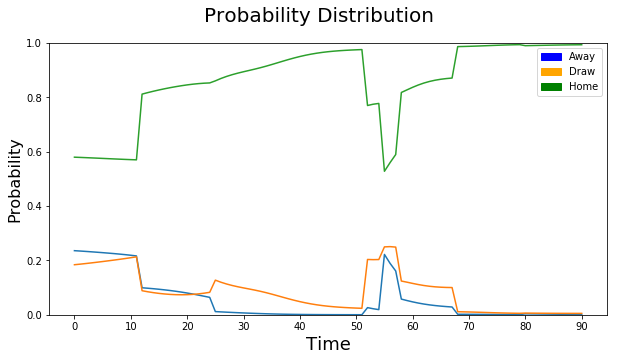

In [142]:
label = "Probability Distribution"
xtick = range(0, 91, 10)
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(10)
a = plt.plot(data[:,0])
d = plt.plot(data[:,1])
h = plt.plot(data[:,2])
fig.suptitle(label, fontsize=20)
dim = 300
plt.ylim([0,1])

plt.xlabel('Time', fontsize=18)
plt.ylabel('Probability', fontsize=16)
blue_patch = mpatches.Patch(color='blue', label='Away')
orange_patch = mpatches.Patch(color='orange', label='Draw')
green_patch = mpatches.Patch(color='green', label='Home')

plt.legend(handles=[blue_patch,orange_patch,green_patch])
plt.xticks(xtick)
plt.show()

In [280]:
X_test_copy= X_test.copy(deep=True)
# X_test_copy = preprocessData(X_test_copy)
X_test_copy['H_Prob'] = np.reciprocal(X_test_copy['B365H']);
X_test_copy['D_Prob'] = np.reciprocal(X_test_copy['B365D']);
X_test_copy['A_Prob'] = np.reciprocal(X_test_copy['B365A']);
X_test_copy['Prob_Sum'] = 0;

def calculate_total_proba(row):
    return (row['H_Prob'] + row['D_Prob'] + row["A_Prob"])*100

X_test_copy['Prob_Sum'] = X_test_copy.apply(calculate_total_proba, axis=1)
# X_test_copy.reset_index(inplace = True)
print "D"

D


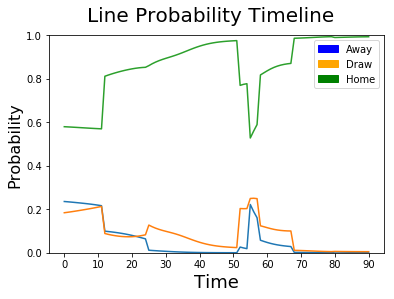

In [140]:
fig = plot_prob_timeline(y_prob,'Line Probability Timeline')
fig.set_figheight(5)
fig.set_figwidth(10)

In [281]:
y_prior = X_test_copy[['A_Prob','D_Prob','H_Prob']]
# 


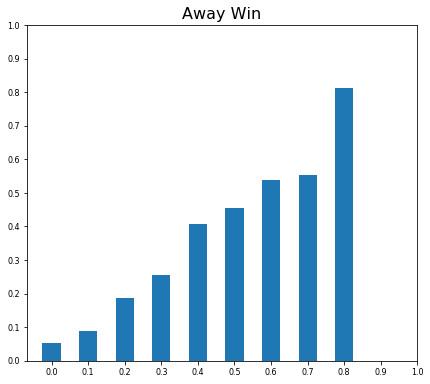

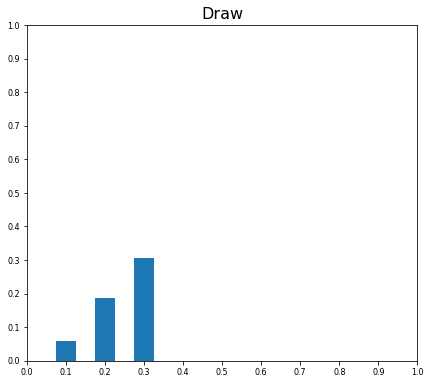

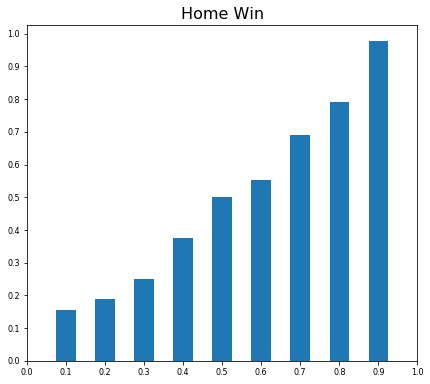

2.139204074355864

In [282]:
eval_probs(y_prior.as_matrix(), y_test, [-1,0,1],show_plot=True)